In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import random
import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as plticker


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import keras_tuner as kt
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Activation, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization, LSTM, TimeDistributed, RepeatVector, Bidirectional, GRU, SimpleRNN, ReLU, GlobalAveragePooling1D
from keras.layers import LSTM
from keras.layers import Dropout, TimeDistributed
from keras.losses import Huber, LogCosh
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# np.set_printoptions(threshold=np.inf)
from keras.utils.vis_utils import plot_model
from keras.utils import set_random_seed
from keras.utils import to_categorical

In [154]:
data = pd.read_csv("./datasets/data4.csv",header=None)

In [155]:
buff = 20
remove_list = ["AMPBTC"]
def all_equal2(iterator):
    return len(set(iterator)) <= 1
"""for j in range(len(data.axes[0])):
    if data.values[j,0] not in remove_list:
        for i in range(1,len(data.axes[1]-buff)):
            if all_equal2(data.values[j,i:i+buff]) and data.values[j,0] not in remove_list:
                remove_list.append(data.values[j,0])
                print(data.values[j,0])"""
print(remove_list)

['AMPBTC']


In [156]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
remove = []
#for i in range(len(data.index)):
#    if data.values[i,0] not in ["GASBUSD","GASBTC"]:
#        remove.append(i)
for coin in remove_list:
    remove += data.index[data[0] == coin ].tolist()

data2=np.delete(data.values,remove,0).transpose()
data2=np.delete(data2,0,0)

In [157]:
def classify_data(max_price_amplitudes):
    num_classes = 5
    classes = []
    for i in range(len(max_price_amplitudes)):
        if max_price_amplitudes[i]<2.5:
            classes.append(0)
        elif max_price_amplitudes[i]>=2.5 and max_price_amplitudes[i]<3.5:
            classes.append(1)
        elif max_price_amplitudes[i]>=3.5 and max_price_amplitudes[i]<5:
            classes.append(2)
        elif max_price_amplitudes[i]>=5 and max_price_amplitudes[i]<7.5:
            classes.append(3)
        else:
            classes.append(4)
            
    return np.asarray(classes).astype("float32"), num_classes
    

In [158]:
expr_name = 'expr_1'
look_back = 700
lstm_layers = 32*2
epochs=2000
batch_size=10


In [159]:
max_price_amplitude = np.zeros([len(data2)]) # in percentage
data3 = np.zeros(np.shape(data2))
for i in range(np.shape(data2)[1]):  
    max_price_amplitude = np.c_[max_price_amplitude, np.ones([len(data2),1])*(max(data2[:,i])/data2[0,i]*100-100)]
    #for j in range(len(data2)):
        #data3[j,i] = data2[j,i]/max(data2[:,i])
scaler = MinMaxScaler(feature_range=(0, 1))
data3 = scaler.fit_transform(data2)
max_price_amplitude = max_price_amplitude[:,1:].reshape([-1,np.shape(data2)[1],1])

In [160]:
classes, num_classes = classify_data(max_price_amplitude[0,:])

In [161]:
def create_dataset(data,points):    
    return data[0:points,:]

In [190]:
train_size_percent = 0.8

points = 30


train_size = int(np.shape(data3)[1] * train_size_percent)
test_size = np.shape(data3)[1] - train_size


trainX = create_dataset(data3[:,:train_size],points).transpose()
#trainX = trainX.reshape(np.shape(trainX)[0],np.shape(trainX)[1],1)
trainY = to_categorical(classes[:train_size],num_classes)
#trainY = max_price_amplitude[0,:train_size,:]

testX = create_dataset(data3[:,train_size:],points).transpose()
#testX = testX.reshape(np.shape(testX)[0],np.shape(testX)[1],1)
testY = to_categorical(classes[train_size:],num_classes)

print('Training dataset length ', train_size)
print('Testing dataset length ', test_size)

Training dataset length  632
Testing dataset length  158


In [209]:
#model = Sequential()
#model.add(LSTM(116, input_shape=(look_back,num_of_features),return_sequences=True))

#model.add(LSTM(44,return_sequences=True))
#model.add(LSTM(96,return_sequences=True))
#model.add(LSTM(68))
#model.add(Dropout(00.05))
#model.add(Dense(1,activation='sigmoid'))
#model.compile(loss=LogCosh(), optimizer='adam')
#history= model.fit(trainX, trainY,validation_split=0.10, epochs=50, batch_size=batch_size,shuffle=False)

#seed = 558438
seed = int(random.random()*1e6)
print(seed)
set_random_seed(
    seed
)

def make_model2(hp):
    input_shape = (points,1)
    input_layer = Input(input_shape)
    model = Sequential()
    model.add(Conv1D(hp.Int('input_filter',min_value=8,max_value=128,step=8), hp.Int('input_kernel_size',min_value=1,max_value=10,step=1), padding="same")(input_layer))
    dropout_rate = hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(ReLU())
    for i in range(hp.Int('n_layers', 1, 6)):
        model.add(Conv1D(hp.Int(f"layer_{i}_filter",min_value=8,max_value=128,step=8), hp.Int(f"layer_{i}_kernel_size",min_value=1,max_value=10,step=1), padding="same"))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())
        model.add(ReLU())

    model.add(GlobalAveragePooling1D())

    model.add(Dense(num_classes, activation=hp.Choice('output_activation',values=['softmax', 'relu','sigmoid'])))
    model.compile(loss="categorical_crossentropy",    metrics=["accuracy"], optimizer=hp.Choice('optimizer',values=['adam', 'sgd']))
    return model

def make_model(input_shape):
    input_layer = Input(input_shape)

    conv1 = Dropout(0.1)(Conv1D(filters=64, kernel_size=3, padding="same")(input_layer))
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Dropout(0.1)(Conv1D(filters=64, kernel_size=3, padding="same")(conv1))
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    conv3 = Dropout(0.1)(Conv1D(filters=64, kernel_size=3, padding="same")(conv2))
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)

    gap = GlobalAveragePooling1D()(conv3)

    output_layer = Dense(num_classes, activation="softmax")(gap)

    return Model(inputs=input_layer, outputs=output_layer)
    """model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(points,1)))    
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    #model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='softmax'))
    model.add(Dense(num_classes, activation='sigmoid'))"""
    return model

"""model = make_model()
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]
callbacks = [
    ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=80, min_lr=0.00005
    ),
    EarlyStopping(monitor="val_loss", patience=100, verbose=1,restore_best_weights=True),
]
model.compile(
    optimizer='sgd',#RMSprop(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    trainX,
    trainY,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)"""


tuner = kt.Hyperband(
    make_model,
    objective='loss',
    max_epochs=25,
    hyperband_iterations=3,
    project_name='tuner5',
    directory='tuners'
    
)
tuner.search(trainX, trainY,
             validation_split=0.1,
             epochs=30, batch_size=batch_size,shuffle=False)
model = tuner.get_best_models(1)[0]

history= model.fit(trainX, trainY,validation_split=0.10, epochs=epochs, batch_size=batch_size,shuffle=False)

620580
(None, 30, 1) <dtype: 'float32'>
(None, 5) <dtype: 'float32'>
input_29 [(None, 30, 1)] float32
conv1d_151 (None, 30, 1) float32
dropout_47 (None, 30, 64) float32
batch_normalization_72 (None, 30, 64) float32
re_lu_72 (None, 30, 64) float32
conv1d_152 (None, 30, 64) float32
dropout_48 (None, 30, 64) float32
batch_normalization_73 (None, 30, 64) float32
re_lu_73 (None, 30, 64) float32
conv1d_153 (None, 30, 64) float32
dropout_49 (None, 30, 64) float32
batch_normalization_74 (None, 30, 64) float32
re_lu_74 (None, 30, 64) float32
global_average_pooling1d_20 (None, 30, 64) float32
dense_97 (None, 64) float32
Epoch 1/2000
51/51 [==============================] - 3s 16ms/step - loss: 1.4563 - accuracy: 0.3743 - val_loss: 1.6125 - val_accuracy: 0.1024 - lr: 0.0100
Epoch 2/2000
51/51 [==============================] - 0s 9ms/step - loss: 1.4164 - accuracy: 0.3921 - val_loss: 1.7006 - val_accuracy: 0.1024 - lr: 0.0100
Epoch 3/2000
51/51 [==============================] - 1s 11ms/step - lo

In [210]:
model = load_model("best_model.h5")

test_loss, test_acc = model.evaluate(testX, testY)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

5/5 [==============================] - 3s 7ms/step - loss: 1.2696 - accuracy: 0.3987
Test accuracy 0.3987341821193695
Test loss 1.269559383392334


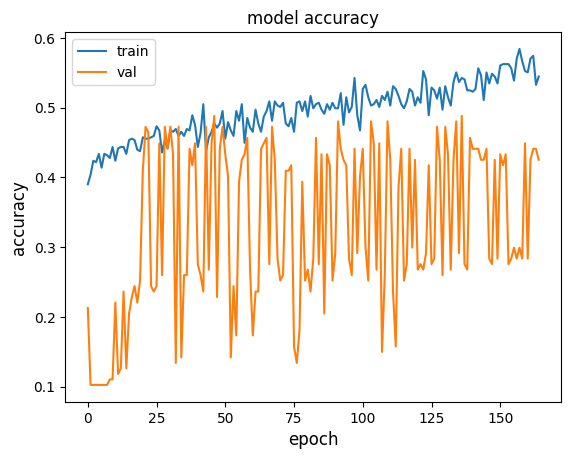

In [208]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()